In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

# Load Data Set here

In [66]:
train = pd.read_csv('train.csv') # This is the label encode version

In [67]:
train = train.drop('Unnamed: 0', axis=1)

In [68]:
train.head()

,device_id,group,phone_brand,device_model,counts,installed,active,label_id
0,-8076087639492063270,10,51,749,-1.0,-1.0,-1.0,-1.0
1,-2897161552818060146,10,51,749,-1.0,-1.0,-1.0,-1.0
2,-8260683887967679142,10,51,749,1.0,53.0,6.0,713.0
3,-4938849341048082022,9,51,1524,-1.0,-1.0,-1.0,-1.0
4,245133531816851882,9,51,753,-1.0,-1.0,-1.0,-1.0


In [69]:
demo = pd.read_csv('gender_age_train.csv')

In [70]:
train = pd.merge(train, demo, how='left', on='device_id')

In [71]:
train.shape[0]

74645

In [72]:
train.head()

,device_id,group_x,phone_brand,device_model,counts,installed,active,label_id,gender,age,group_y
0,-8076087639492063270,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38
1,-2897161552818060146,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38
2,-8260683887967679142,10,51,749,1.0,53.0,6.0,713.0,M,35,M32-38
3,-4938849341048082022,9,51,1524,-1.0,-1.0,-1.0,-1.0,M,30,M29-31
4,245133531816851882,9,51,753,-1.0,-1.0,-1.0,-1.0,M,30,M29-31


# Data Visualisation

# Age and gender distributions

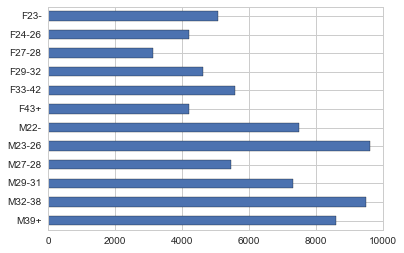

In [17]:
train.group_y.value_counts().sort_index(ascending=False).plot(kind='barh')

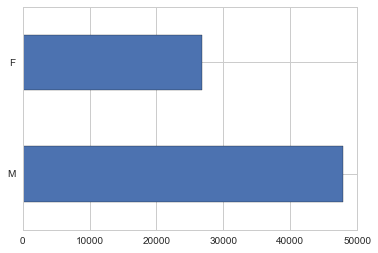

In [18]:
train.gender.value_counts().plot(kind='barh')

# Looks like we have more male samples than female.

•	Males were more likely to participate and grant permission for use of their details

•	males in general own more phones than females

•	the one-child policy has resulted in a disproportionately high percentage of Males.

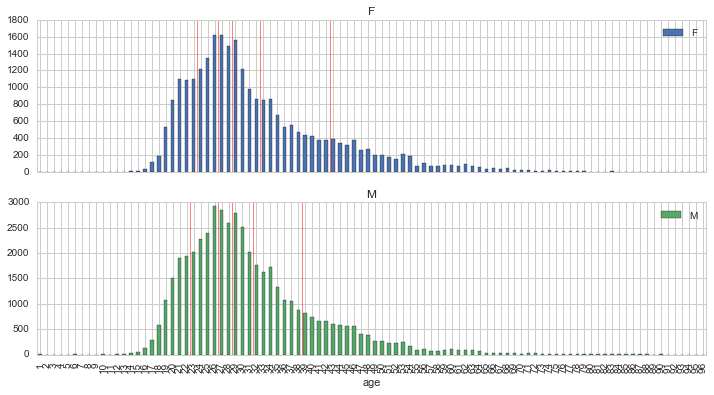

In [26]:
c = train.groupby(['age','gender']).size().unstack().reindex(index=np.arange(train.age.min(), 
                                                                            train.age.max()+1)).fillna(0)
ax1, ax2 = c.plot(kind='bar', figsize=(12,6),subplots=True)
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

# Brands and Models popularity

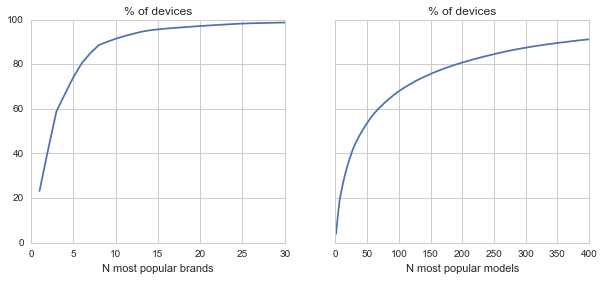

In [27]:
c = train.phone_brand.value_counts()
s = c.cumsum()/c.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(np.arange(s.shape[0])+1, s.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_title('% of devices');
c = train.device_model.value_counts()
s = c.cumsum()/c.sum()
ax2.plot(np.arange(s.shape[0])+1, s.values*100)
ax2.set_xlim(0,400)
ax2.set_xlabel('N most popular models')
ax2.set_title('% of devices');

# 9 most popular brands account for 90% of devices. 

For models the number to account for 90% of devices is 373.

In [30]:
import matplotlib.cm as cm

In [31]:
def plot_by(df, cat, by, perc = 0.95):
    # Find popular categories
    c = df[by].value_counts().cumsum()/df.shape[0]
    take = c[c<=perc].index
    
    # Pool rare categories into 'other' cat
    gr = df[by].copy()
    gr[~(df[by].isin(take))] = 'other'
    
    # Count target classes in groups
    c = df.groupby([gr,cat]).size().unstack().fillna(0)
    total = c.sum(axis=1)
    meanprobs = c.sum(axis=0).cumsum()/df.shape[0]
    
    # Transform to probabilities
    sortcol = c.columns[int(np.floor((c.shape[1]-1)/2))]
    c = c.div(c.sum(axis=1), axis='index')
    
    # Cumsum for stacked bars
    c = c.cumsum(axis=1).sort_values(by=sortcol)
    total = total.loc[c.index]
    
    # Prepare plot data
    left = np.zeros(total.shape[0])
    left[1:] = total.cumsum().values[:-1]
    ticks = left + 0.5*total.values
    colors = cm.rainbow(np.linspace(0.1,0.9,num=c.shape[1]))
    fig, ax = plt.subplots(figsize=(10,5))
    for (i,col) in enumerate(c.columns[::-1]):
        height = c[col].values
        ax.bar(left, height, total.values,label=col,color=colors[i],zorder = c.shape[0]+i)
    for p in meanprobs.iloc[:-1]:
        ax.hlines(p, 0, total.sum(),
                  color='w',alpha=0.6,zorder=c.shape[0]*10,linewidth=1)
        
    # legend placement needs more work
    ax.legend(bbox_to_anchor=(1.1, 0.8),title=cat)
    ax.set_xticks(ticks)
    ax.set_xticklabels(total.index, rotation='vertical')
    ax.set_xlabel(by)
    ax.set_xlim(0,left[-1]+total.values[-1])
    return ax

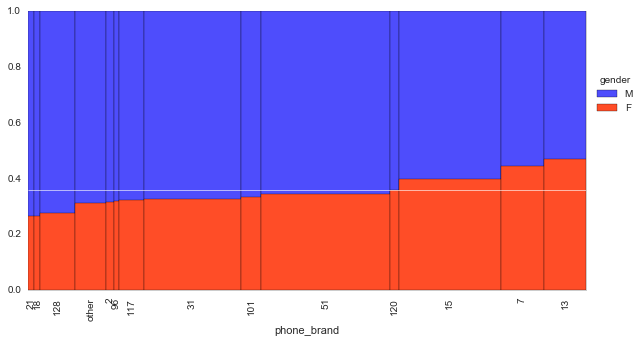

In [32]:
ax = plot_by(train, 'gender', 'phone_brand')

In [34]:
plt.savefig('Demo.png')

In [73]:
brand = pd.read_csv('phone_brand_device_model.csv')

In [74]:
train = pd.merge(train, brand, how='left', on='device_id')

In [75]:
train.shape[0]

74839

In [76]:
train.drop_duplicates('device_id', keep='first', inplace=True)

In [77]:
train.shape[0]

74645

In [78]:
train.head()

,device_id,group_x,phone_brand_x,device_model_x,counts,installed,active,label_id,gender,age,group_y,phone_brand_y,device_model_y
0,-8076087639492063270,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,小米,MI 2
1,-2897161552818060146,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,小米,MI 2
2,-8260683887967679142,10,51,749,1.0,53.0,6.0,713.0,M,35,M32-38,小米,MI 2
3,-4938849341048082022,9,51,1524,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,小米,红米note
4,245133531816851882,9,51,753,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,小米,MI 3


In [79]:
english_phone_brands_mapping = {
    "三星": "samsung",
    "天语": "Ktouch",
    "海信": "hisense",
    "联想": "lenovo",
    "欧比": "obi",
    "爱派尔": "ipair",
    "努比亚": "nubia",
    "优米": "youmi",
    "朵唯": "dowe",
    "黑米": "heymi",
    "锤子": "hammer",
    "酷比魔方": "koobee",
    "美图": "meitu",
    "尼比鲁": "nibilu",
    "一加": "oneplus",
    "优购": "yougo",
    "诺基亚": "nokia",
    "糖葫芦": "candy",
    "中国移动": "ccmc",
    "语信": "yuxin",
    "基伍": "kiwu",
    "青橙": "greeno",
    "华硕": "asus",
    "夏新": "panosonic",
    "维图": "weitu",
    "艾优尼": "aiyouni",
    "摩托罗拉": "moto",
    "乡米": "xiangmi",
    "米奇": "micky",
    "大可乐": "bigcola",
    "沃普丰": "wpf",
    "神舟": "hasse",
    "摩乐": "mole",
    "飞秒": "fs",
    "米歌": "mige",
    "富可视": "fks",
    "德赛": "desci",
    "梦米": "mengmi",
    "乐视": "lshi",
    "小杨树": "smallt",
    "纽曼": "newman",
    "邦华": "banghua",
    "E派": "epai",
    "易派": "epai",
    "普耐尔": "pner",
    "欧新": "ouxin",
    "西米": "ximi",
    "海尔": "haier",
    "波导": "bodao",
    "糯米": "nuomi",
    "唯米": "weimi",
    "酷珀": "kupo",
    "谷歌": "google",
    "昂达": "ada",
    "聆韵": "lingyun",
    "小米": "Xiaomi",
    "华为": "Huawei",
    "魅族": "Meizu",
    "中兴": "ZTE",
    "酷派": "Coolpad",
    "金立": "Gionee",
    "SUGAR": "SUGAR",
    "OPPO": "OPPO",
    "vivo": "vivo",
    "HTC": "HTC",
    "LG": "LG",
    "ZUK": "ZUK",
    "TCL": "TCL",
    "LOGO": "LOGO",
    "SUGAR": "SUGAR",
    "Lovme": "Lovme",
    "PPTV": "PPTV",
    "ZOYE": "ZOYE",
    "MIL": "MIL",
    "索尼" : "Sony",
    "欧博信" : "Opssom",
    "奇酷" : "Qiku",
    "酷比" : "CUBE",
    "康佳" : "Konka",
    "亿通" : "Yitong",
    "金星数码" : "JXD",
    "至尊宝" : "Monkey King",
    "百立丰" : "Hundred Li Feng",
    "贝尔丰" : "Bifer",
    "百加" : "Bacardi",
    "诺亚信" : "Noain",
    "广信" : "Kingsun",
    "世纪天元" : "Ctyon",
    "青葱" : "Cong",
    "果米" : "Taobao",
    "斐讯" : "Phicomm",
    "长虹" : "Changhong",
    "欧奇" : "Oukimobile",
    "先锋" : "XFPLAY",
    "台电" : "Teclast",
    "大Q" : "Daq",
    "蓝魔" : "Ramos",
    "奥克斯" : "AUX"
}

In [80]:
# Now, we map the english translation into the current phone_brand
train.phone_brand_y = train.phone_brand_y.map(pd.Series(english_phone_brands_mapping), na_action='ignore')

In [81]:
train.head()

,device_id,group_x,phone_brand_x,device_model_x,counts,installed,active,label_id,gender,age,group_y,phone_brand_y,device_model_y
0,-8076087639492063270,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,Xiaomi,MI 2
1,-2897161552818060146,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,Xiaomi,MI 2
2,-8260683887967679142,10,51,749,1.0,53.0,6.0,713.0,M,35,M32-38,Xiaomi,MI 2
3,-4938849341048082022,9,51,1524,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,Xiaomi,红米note
4,245133531816851882,9,51,753,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,Xiaomi,MI 3


In [82]:
del brand

In [83]:
del demo

# Age distribution by phone brand

Color = gender

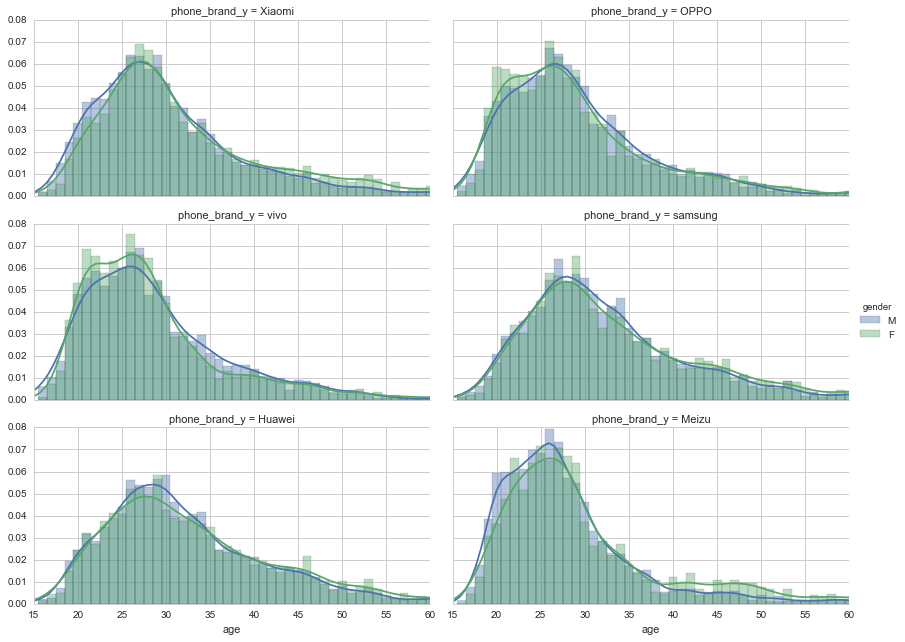

In [56]:
brands = train.phone_brand_y.value_counts().index[:6]
c = train[train.phone_brand_y.isin(brands)]
g = sns.FacetGrid(c, hue='gender', col='phone_brand_y',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5).add_legend()

In [57]:
g.savefig('Age Dist.png')

In [88]:
# Reading events to incroporate latitude and longitude for map plotting to see if pattern emerge
events = pd.read_csv('events.csv')

In [89]:
events.head()

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


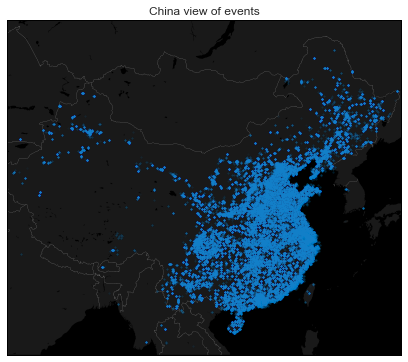

In [91]:
from mpl_toolkits.basemap import Basemap
# Sample it down to only the China region
lon_min, lon_max = 75, 135
lat_min, lat_max = 15, 55

idx_china = (events["longitude"]>lon_min) &\
            (events["longitude"]<lon_max) &\
            (events["latitude"]>lat_min) &\
            (events["latitude"]<lat_max)

df_events_china = events[idx_china]

# Mercator of China
plt.figure(2, figsize=(12,6))

m2 = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='i')

m2.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m2.drawmapboundary(fill_color='#000000')                # black background
m2.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders

# Plot the data
mxy = m2(df_events_china["longitude"].tolist(), df_events_china["latitude"].tolist())
m2.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.05, zorder=5)

plt.title("China view of events")
plt.show()

In [95]:
# How to save above image to png?
plt.savefig('China_events.png')

In [96]:
del events

In [97]:
train.head()

,device_id,group_x,phone_brand_x,device_model_x,counts,installed,active,label_id,gender,age,group_y,phone_brand_y,device_model_y
0,-8076087639492063270,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,Xiaomi,MI 2
1,-2897161552818060146,10,51,749,-1.0,-1.0,-1.0,-1.0,M,35,M32-38,Xiaomi,MI 2
2,-8260683887967679142,10,51,749,1.0,53.0,6.0,713.0,M,35,M32-38,Xiaomi,MI 2
3,-4938849341048082022,9,51,1524,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,Xiaomi,红米note
4,245133531816851882,9,51,753,-1.0,-1.0,-1.0,-1.0,M,30,M29-31,Xiaomi,MI 3


In [98]:
del train

# Cleaning Data

# Lets start with application events file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read application events data
ape = pd.read_csv("app_events.csv")

In [3]:
ape['installed'] = ape.groupby(['event_id'])['is_installed'].transform('sum')

In [4]:
ape.head()

,event_id,app_id,is_installed,is_active,installed
0,2,5927333115845830913,1,1,19
1,2,-5720078949152207372,1,0,19
2,2,-1633887856876571208,1,0,19
3,2,-653184325010919369,1,1,19
4,2,8693964245073640147,1,1,19


In [5]:
ape['active'] = ape.groupby(['event_id'])['is_active'].transform('sum')

In [6]:
ape.head()

,event_id,app_id,is_installed,is_active,installed,active
0,2,5927333115845830913,1,1,19,6
1,2,-5720078949152207372,1,0,19,6
2,2,-1633887856876571208,1,0,19,6
3,2,-653184325010919369,1,1,19,6
4,2,8693964245073640147,1,1,19,6


In [7]:
ape.drop(['is_installed', 'is_active'], axis=1, inplace=True)

In [8]:
ape.head()

,event_id,app_id,installed,active
0,2,5927333115845830913,19,6
1,2,-5720078949152207372,19,6
2,2,-1633887856876571208,19,6
3,2,-653184325010919369,19,6
4,2,8693964245073640147,19,6


In [10]:
# Reading app labels
apl = pd.read_csv('app_labels.csv')
lct = pd.read_csv('label_categories.csv')

In [11]:
act = pd.merge(apl, lct, how='left', on='label_id')

In [12]:
act.head()

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown
3,6058196446775239644,407,DS_P2P net loan
4,8694625920731541625,406,unknown


In [13]:
ape.drop_duplicates('event_id', keep='first', inplace=True)

In [14]:
ape = pd.merge(ape, act, how='left', on='app_id')

In [15]:
ape.head()

,event_id,app_id,installed,active,label_id,category
0,2,5927333115845830913,19,6,549,Property Industry 1.0
1,2,5927333115845830913,19,6,710,Relatives 1
2,2,5927333115845830913,19,6,704,Property Industry 2.0
3,2,5927333115845830913,19,6,548,Industry tag
4,2,5927333115845830913,19,6,172,IM


In [16]:
ape.drop(['app_id'], axis=1, inplace=True)

In [17]:
ape.head()

,event_id,installed,active,label_id,category
0,2,19,6,549,Property Industry 1.0
1,2,19,6,710,Relatives 1
2,2,19,6,704,Property Industry 2.0
3,2,19,6,548,Industry tag
4,2,19,6,172,IM


# Reading events file here

In [18]:
events = pd.read_csv('events.csv', dtype={'device_id': np.str})

In [19]:
# Count of number of times an event is happening for a device
events['event_counts'] = events.groupby(['device_id'])['event_id'].transform('count')

In [20]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,event_counts
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,256
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,248
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,47
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,525


In [21]:
# The idea here is to count the number of installed apps using the data
# from app_events.csv above. Also to count the number of active apps.
events = pd.merge(events, ape, how='left', on='event_id', left_index=True)

In [22]:
events.head()

,event_id,device_id,timestamp,longitude,latitude,event_counts,installed,active,label_id,category
8463466,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,256,NaN,NaN,NaN,NaN
0,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73,19.0,6.0,549.0,Property Industry 1.0
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73,19.0,6.0,710.0,Relatives 1
2,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73,19.0,6.0,704.0,Property Industry 2.0
3,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,73,19.0,6.0,548.0,Industry tag


In [24]:
events_small = events[['device_id', 'event_counts', 'installed', 'active', 'category']].drop_duplicates('device_id', keep='first')

In [25]:
events_small.head()

,device_id,event_counts,installed,active,category
8463466,29182687948017175,256,NaN,NaN,NaN
0,-6401643145415154744,73,19.0,6.0,Property Industry 1.0
8463466,-4833982096941402721,248,NaN,NaN,NaN
8463466,-6815121365017318426,47,NaN,NaN,NaN
8463466,-5373797595892518570,525,NaN,NaN,NaN


# Phone Brand

In [26]:
pbd = pd.read_csv("phone_brand_device_model.csv", dtype={'device_id': np.str})

In [27]:
pbd.drop_duplicates('device_id', keep='first', inplace=True)

In [28]:
pbd.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [29]:
# Training Data
train = pd.read_csv("gender_age_train.csv", dtype={'device_id': np.str})

In [30]:
train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [31]:
train = pd.merge(train, pbd, how='left', on='device_id', left_index=True)

In [32]:
train.head()

,device_id,gender,age,group,phone_brand,device_model
56800,-8076087639492063270,M,35,M32-38,小米,MI 2
41294,-2897161552818060146,M,35,M32-38,小米,MI 2
9993,-8260683887967679142,M,35,M32-38,小米,MI 2
179893,-4938849341048082022,M,30,M29-31,小米,红米note
102570,245133531816851882,M,30,M29-31,小米,MI 3


In [33]:
train = pd.merge(train, events_small, how='left', on='device_id', left_index=True)

In [34]:
train.head()

,device_id,gender,age,group,phone_brand,device_model,event_counts,installed,active,category
8460527,-8076087639492063270,M,35,M32-38,小米,MI 2,NaN,NaN,NaN,NaN
8460527,-2897161552818060146,M,35,M32-38,小米,MI 2,NaN,NaN,NaN,NaN
6455195,-8260683887967679142,M,35,M32-38,小米,MI 2,1.0,53.0,6.0,Services 1
8460527,-4938849341048082022,M,30,M29-31,小米,红米note,NaN,NaN,NaN,NaN
8460527,245133531816851882,M,30,M29-31,小米,MI 3,NaN,NaN,NaN,NaN


In [35]:
train.to_csv('train-before-encode.csv')

# Label Encode

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
letarget = LabelEncoder().fit(train.group.values)
train['Groups'] = letarget.transform(train.group)

In [40]:
lebrand = LabelEncoder().fit(train.phone_brand)
train['brand'] = lebrand.transform(train.phone_brand)
m = train.phone_brand.str.cat(train.device_model)
lemodel = LabelEncoder().fit(m)
train['model'] = lemodel.transform(m)

In [43]:
lecategory = LabelEncoder().fit(train.category)
train['Category'] = lecategory.transform(train.category)

C:\Users\richter Belmont\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [44]:
train.head()

,device_id,gender,age,group,phone_brand,device_model,event_counts,installed,active,category,Groups,brand,model,Category
8460527,-8076087639492063270,M,35,M32-38,小米,MI 2,NaN,NaN,NaN,NaN,10,47,761,0
8460527,-2897161552818060146,M,35,M32-38,小米,MI 2,NaN,NaN,NaN,NaN,10,47,761,0
6455195,-8260683887967679142,M,35,M32-38,小米,MI 2,1.0,53.0,6.0,Services 1,10,47,761,72
8460527,-4938849341048082022,M,30,M29-31,小米,红米note,NaN,NaN,NaN,NaN,9,47,783,0
8460527,245133531816851882,M,30,M29-31,小米,MI 3,NaN,NaN,NaN,NaN,9,47,765,0


In [45]:
# Impute the N/A with -1
train.fillna(-1, inplace=True)

In [46]:
train.head()

,device_id,gender,age,group,phone_brand,device_model,event_counts,installed,active,category,Groups,brand,model,Category
8460527,-8076087639492063270,M,35,M32-38,小米,MI 2,-1.0,-1.0,-1.0,-1,10,47,761,0
8460527,-2897161552818060146,M,35,M32-38,小米,MI 2,-1.0,-1.0,-1.0,-1,10,47,761,0
6455195,-8260683887967679142,M,35,M32-38,小米,MI 2,1.0,53.0,6.0,Services 1,10,47,761,72
8460527,-4938849341048082022,M,30,M29-31,小米,红米note,-1.0,-1.0,-1.0,-1,9,47,783,0
8460527,245133531816851882,M,30,M29-31,小米,MI 3,-1.0,-1.0,-1.0,-1,9,47,765,0


In [47]:
train.shape[0]

74645

In [48]:
train.to_csv('train_label_encoded.csv')

# Test file

In [57]:
test = pd.read_csv("gender_age_test.csv", dtype={'device_id': np.str})

In [58]:
test = pd.merge(test, pbd, how='left', on='device_id', left_index=True)

In [59]:
test = pd.merge(test, events_small, how='left', on='device_id', left_index=True)

In [61]:
test.head()

,device_id,phone_brand,device_model,event_counts,installed,active,category
1199784,1002079943728939269,小米,小米note,7.0,37.0,2.0,Property Industry 1.0
482597,-1547860181818787117,小米,红米2,8.0,21.0,8.0,Services 1
3243286,7374582448058474277,华为,Y523-L176,5.0,11.0,3.0,Irritation / Fun 1
844354,-6220210354783429585,华为,荣耀6,9.0,34.0,17.0,Property Industry 1.0
8460527,-5893464122623104785,小米,MI 2,NaN,NaN,NaN,NaN


In [62]:
lebrand_t = LabelEncoder().fit(test.phone_brand)
test['brand'] = lebrand_t.transform(test.phone_brand)
m = test.phone_brand.str.cat(test.device_model)
lemodel_t = LabelEncoder().fit(m)
test['model'] = lemodel_t.transform(m)
lecategory_t = LabelEncoder().fit(test.category)
test['Category'] = lecategory_t.transform(test.category)

In [63]:
test.head()

,device_id,phone_brand,device_model,event_counts,installed,active,category,brand,model,Category
1199784,1002079943728939269,小米,小米note,7.0,37.0,2.0,Property Industry 1.0,49,822,67
482597,-1547860181818787117,小米,红米2,8.0,21.0,8.0,Services 1,49,825,78
3243286,7374582448058474277,华为,Y523-L176,5.0,11.0,3.0,Irritation / Fun 1,29,692,52
844354,-6220210354783429585,华为,荣耀6,9.0,34.0,17.0,Property Industry 1.0,29,709,67
8460527,-5893464122623104785,小米,MI 2,NaN,NaN,NaN,NaN,49,808,0


In [64]:
test.to_csv('test_encoded.csv')

In [66]:
# Impute the N/A with -1
test.fillna(-1, inplace=True)

In [67]:
test.head()

,device_id,phone_brand,device_model,event_counts,installed,active,category,brand,model,Category
1199784,1002079943728939269,小米,小米note,7.0,37.0,2.0,Property Industry 1.0,49,822,67
482597,-1547860181818787117,小米,红米2,8.0,21.0,8.0,Services 1,49,825,78
3243286,7374582448058474277,华为,Y523-L176,5.0,11.0,3.0,Irritation / Fun 1,29,692,52
844354,-6220210354783429585,华为,荣耀6,9.0,34.0,17.0,Property Industry 1.0,29,709,67
8460527,-5893464122623104785,小米,MI 2,-1.0,-1.0,-1.0,-1,49,808,0


In [68]:
test.shape[0]

112071

In [69]:
features = list(test.columns.values)

In [70]:
features

['device_id',
 'phone_brand',
 'device_model',
 'event_counts',
 'installed',
 'active',
 'category',
 'brand',
 'model',
 'Category']

In [71]:
features.remove('device_id')

In [72]:
features

['phone_brand',
 'device_model',
 'event_counts',
 'installed',
 'active',
 'category',
 'brand',
 'model',
 'Category']

In [73]:
del events_small, events, pbd, ape, act

In [75]:
del apl

# Cleaning Done!

# Let's do Modelling!

In [78]:
X = train[['brand', 'model', 'Category', 'installed', 'active', 'event_counts']]

In [79]:
y = train['Groups']

# Before that.....Feature Selection!

# Variance Threshold

In [80]:
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2

In [82]:
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = train.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

C:\Users\richter Belmont\Anaconda2\lib\site-packages\pandas\indexes\base.py:1267: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 14 but corresponding boolean dimension is 6
  result = getitem(key)


Index([u'device_id', u'gender', u'age', u'group', u'phone_brand',
       u'device_model'],
      dtype='object')

# Important Features...

using Random Forest Classifier

In [83]:
import sklearn.ensemble

In [84]:
model = sklearn.ensemble.RandomForestClassifier()

In [85]:
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance'])
feat_imp_sort = feature_imp.sort_values('Importance', ascending=False).head(20).index
feat_imp_sort

Index([u'model', u'event_counts', u'installed', u'active', u'Category',
       u'brand'],
      dtype='object')

# Evaluating Algorithms

# 1) Decision Tree

In [87]:
import sklearn.tree

In [89]:
# Using just 3 features (brand, model, categories)
X1 = X.drop(['event_counts', 'installed', 'active'], axis=1)

In [116]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=4)

In [117]:
dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [118]:
X.head()

,brand,model,Category,installed,active,event_counts
8460527,47,761,0,-1.0,-1.0,-1.0
8460527,47,761,0,-1.0,-1.0,-1.0
6455195,47,761,72,53.0,6.0,1.0
8460527,47,783,0,-1.0,-1.0,-1.0
8460527,47,765,0,-1.0,-1.0,-1.0


In [119]:
zip(dt.predict(X),y)

[(7, 10),
 (7, 10),
 (7, 10),
 (7, 9),
 (7, 9),
 (0, 1),
 (7, 10),
 (7, 10),
 (0, 10),
 (10, 4),
 (7, 9),
 (10, 4),
 (10, 2),
 (10, 10),
 (7, 11),
 (11, 2),
 (7, 10),
 (7, 10),
 (6, 11),
 (7, 10),
 (10, 4),
 (7, 7),
 (7, 7),
 (10, 8),
 (7, 9),
 (10, 10),
 (10, 10),
 (10, 4),
 (10, 10),
 (11, 10),
 (7, 10),
 (0, 10),
 (7, 6),
 (7, 9),
 (7, 10),
 (10, 10),
 (0, 7),
 (7, 10),
 (7, 10),
 (10, 9),
 (6, 8),
 (6, 6),
 (7, 9),
 (10, 9),
 (10, 8),
 (10, 8),
 (10, 8),
 (10, 8),
 (7, 2),
 (7, 9),
 (7, 4),
 (7, 9),
 (7, 9),
 (10, 4),
 (10, 4),
 (7, 10),
 (7, 10),
 (7, 10),
 (7, 11),
 (0, 9),
 (7, 7),
 (7, 7),
 (10, 10),
 (11, 8),
 (7, 11),
 (10, 8),
 (7, 10),
 (7, 2),
 (10, 10),
 (7, 8),
 (0, 11),
 (7, 11),
 (7, 11),
 (10, 8),
 (11, 6),
 (7, 8),
 (0, 5),
 (11, 5),
 (7, 7),
 (7, 11),
 (7, 10),
 (7, 10),
 (7, 10),
 (10, 9),
 (7, 5),
 (11, 8),
 (10, 11),
 (10, 11),
 (10, 7),
 (7, 11),
 (7, 10),
 (10, 11),
 (11, 11),
 (11, 7),
 (7, 5),
 (7, 9),
 (6, 0),
 (6, 0),
 (10, 9),
 (7, 9),
 (7, 2),
 (6, 2),
 (

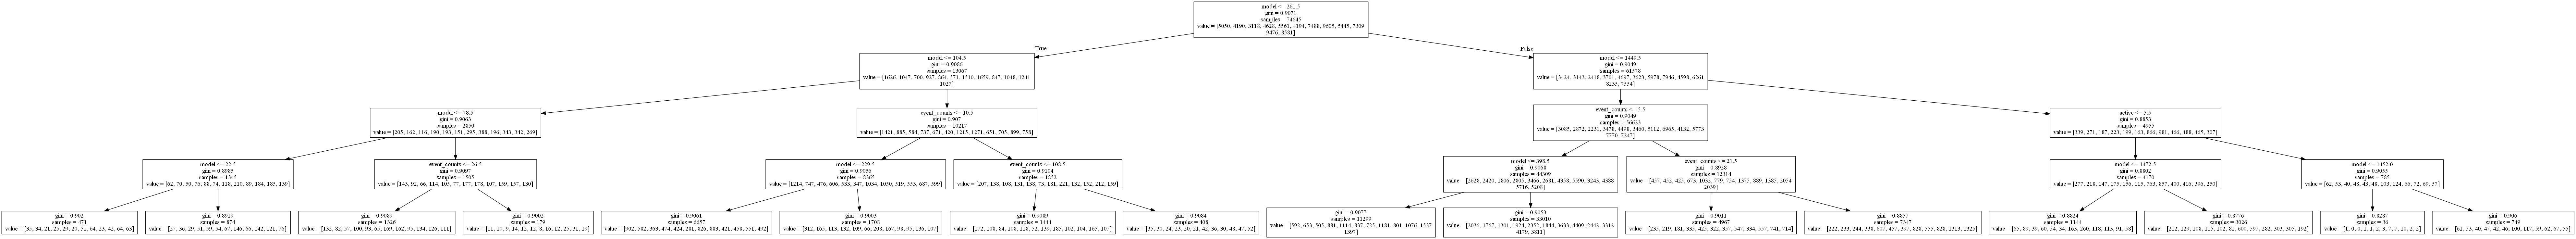

In [120]:
import StringIO
s = StringIO.StringIO()
sklearn.tree.export_graphviz(dt, out_file=s, feature_names=['brand', 'model','Category', 'installed', 'active', 'event_counts'])

import pydotplus
graph = pydotplus.graph_from_dot_data(s.getvalue())
import IPython.display
IPython.display.Image(graph.create_png())

In [95]:
import sklearn.cross_validation

In [121]:
sklearn.cross_validation.cross_val_score(dt, X, y, cv=5, scoring='accuracy').mean()

0.1419252130250844

In [122]:
sklearn.cross_validation.cross_val_score(dt, X, y, cv=5, scoring='log_loss')

array([-2.41275418, -2.40876211, -2.41270902, -2.40419431, -2.42053157])

# Algorithm Spot-check

In [124]:
from sklearn.linear_model import LogisticRegression
seed = 7
processors=1
num_folds=5
num_instances=len(X)
scoring='accuracy'

kfold = sklearn.cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)

# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('K-NN', KNeighborsClassifier(n_neighbors=5)))
models.append(('CART', sklearn.tree.DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVC', SVC(probability=True)))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = sklearn.cross_validation.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.140) +/- (0.009)
CART: (0.128) +/- (0.004)


# Ensemble...

1) Bagged Decision Trees

In [125]:
cart = sklearn.tree.DecisionTreeClassifier()
num_trees = 100

model = sklearn.ensemble.BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = sklearn.cross_validation.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.131) +/- (0.004)


2) Random Forest

In [106]:
num_trees = 100
num_features = 3

model = sklearn.ensemble.RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = sklearn.cross_validation.cross_val_score(model, X1, y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

(0.134) +/- (0.003)


# Hyper-parameter tuning / Brute Force

# 1) Decision Tree

In [108]:
rf_grid = sklearn.grid_search.GridSearchCV(
    estimator = sklearn.tree.DecisionTreeClassifier(),
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_features': [1, 3],
        'max_depth': [3, 25],
        }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X1, y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.138951034899
{'max_features': 3, 'criterion': 'gini', 'max_depth': 3}


# 2) Random Forest

In [109]:
rf_grid = sklearn.grid_search.GridSearchCV(
    estimator = sklearn.ensemble.RandomForestClassifier(warm_start=True, random_state=seed),
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ['gini', 'entropy'],
        'max_features': [1, 3],
        'max_depth': [3, 25],
        'bootstrap': [True]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X1, y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

0.138214213946
{'max_features': 1, 'n_estimators': 100, 'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3}
